In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

import esmtools as et
from esmtools import stats

import shapefile
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gp
import regionmask
import matplotlib.patches as mpatches

In [2]:
# Open dataset for DIC
dir = '/home/jovyan/SOARS_2021/Data/Obs/BGC/'
fn_dissic = 'OceanSODA-ETHZ_1985-2019_v2020b.nc'

data_dissic = xr.open_dataset(dir+fn_dissic)
#data_dissic 

In [3]:
dissic = data_dissic['DIC']

In [4]:
#data_dissic['time'] = pd.date_range("1980-01", "2018-12", freq="MS")
dissic = dissic.sel(lat=slice(0,70), lon=slice(-170,-90))
dissic

<xarray.DataArray 'DIC' (time: 408, lat: 70, lon: 80)>
[2284800 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 65.5 66.5 67.5 68.5 69.5
  * lon      (lon) float64 -169.5 -168.5 -167.5 -166.5 ... -92.5 -91.5 -90.5
  * time     (time) datetime64[ns] 1985-01-01 1985-02-01 ... 2018-12-01
Attributes:
    description:    DIC calculated with pyCO2SYS
    short_name:     dic
    standard_name:  dissolved_inorganic_carbon_in_sea_water
    units:          umol/kg

In [5]:
# Adjust the units to mmol / m^3 
dissic = (dissic / 1000)*1025

In [6]:
# remove long term trend for each grid cell
var = stats.rm_poly(dissic,order=2,dim='time',nan_policy='drop')
#var = dissic 

/home/jovyan/my-conda-envs/myenv/lib/python3.8/site-packages/numpy/polynomial/polynomial.py:1361: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


In [7]:
# 1982-2010 period
base = var.sel(time=slice('1985-01','2010-12'))
dissic_base = base

In [8]:
# Blob period
blob = var.sel(time=slice('2013-07','2016-06'))
tos_blob = blob

In [9]:
# Difference between the two periods
blob_anom = blob.groupby('time.month') - base.groupby('time.month').mean()

In [10]:
# Resample to two month resolution
cesm = blob_anom.resample(time='2M').mean()
cesm

<xarray.DataArray (lat: 70, lon: 80, time: 19)>
array([[[ 14.14424378,  16.24562608,  17.93422835, ..., -55.28232212,
         -10.82914912,  -9.08571209],
        [ 13.08188894,  15.95070105,  17.43665755, ..., -54.33620306,
         -10.6872506 ,  -8.96399444],
        [ 12.34534114,  15.82394391,  17.37069879, ..., -54.71618783,
          -9.88273973,  -7.45718186],
        ...,
        [  4.47184423,   3.24310215,  -0.52477168, ..., -29.14122419,
          16.60465981,  20.92530821],
        [  5.34939811,   6.47934729,   7.8221572 , ..., -31.43513853,
          15.46883988,  14.7974643 ],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[ 18.09109325,  19.12644834,  19.43977667, ..., -41.90413579,
          -9.76151924,  -9.26452204],
        [ 17.07235786,  17.18915146,  19.07338096, ..., -41.16854423,
          -8.74439639,  -7.97408277],
        [ 13.8737407 ,  17.12879566,  18.13692155, ..., -41.58967367,
          -8.99640679,  -7.44970281],
...
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[         nan,   1.04322495,  19.29702227, ...,          nan,
                  nan,          nan],
        [         nan,  -5.59788474,  16.67304931, ...,          nan,
                  nan,          nan],
        [         nan,  -4.45310523,  15.99182067, ...,          nan,
                  nan,          nan],
        ...,
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]]])
Coordinates:
  * time     (time) datetime64[ns] 2013-07-31 2013-09-30 ... 2016-07-31
  * lat      (lat) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 65.5 66.5 67.5 68.5 69.5
  * lon      (lon) float64 -169.5 -168.5 -167.5 -166.5 ... -92.5 -91.5 -90.5

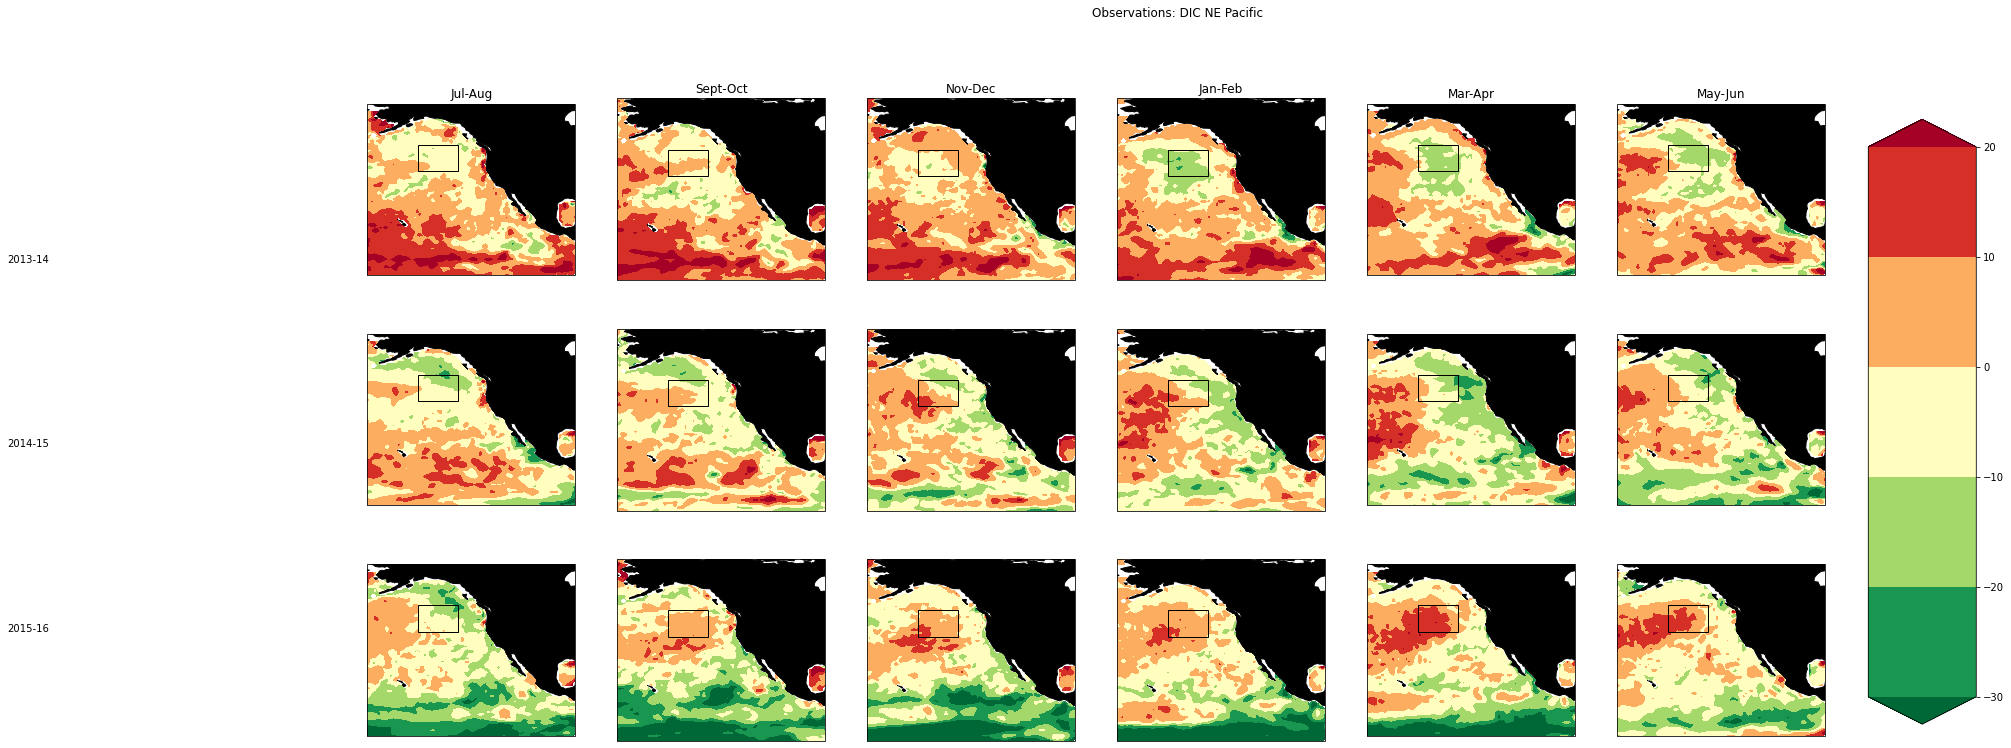

In [12]:
def panels(data,description,variable,depth,lower_bound,upper_bound, step,cmap):
    f, axs = plt.subplots(nrows=3,ncols=6,figsize=(30,12),
                          subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180))) 
    axs = axs.flatten()
    for i in range(0,18):
        im = axs[i].contourf(cesm.lon, cesm.lat, cesm.isel(time=i),
                         transform=ccrs.PlateCarree(), 
                         cmap=cmap,
                         levels=np.arange(lower_bound, upper_bound, step),
                         extend='both')
        axs[i].add_feature(cfeature.LAND, color='k')
        axs[i].add_patch(mpatches.Rectangle(xy=[210, 40], width=15, height=10,
                                    edgecolor='k',
                                    facecolor='none',
                                    transform=ccrs.PlateCarree())
                 )
    plt.suptitle("Observations: " + description + " " + variable + " " + depth)
    axs[0].set_title("Jul-Aug"); axs[1].set_title("Sept-Oct")
    axs[2].set_title("Nov-Dec"); axs[3].set_title("Jan-Feb")
    axs[4].set_title("Mar-Apr"); axs[5].set_title("May-Jun")
    plt.text(-600,180,'2013-14')
    plt.text(-600,110,'2014-15')
    plt.text(-600,40,'2015-16')
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes([0.82, 0.15, 0.05, 0.7])
    f.colorbar(im, cax=cbar_ax,fraction=0.046,pad=0.04)
    
panels(dissic,'DIC','NE','Pacific',-30.0,30.0, 10.0,'RdYlGn_r')